In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Distgen basic usage
--------------------

In [47]:
# Generator is the main object that creates a beam distribution
from distgen import Generator

In [48]:
# Basic Example using a json file:
input_file = "data/rad.gaussian.in.json"

In [49]:
# Create a generator object
gen = Generator(input_file, verbose=1) 

# Generate distribution, return the beam 
beam = gen.beam()

# Print some stats
beam.print_stats()

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution:       Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Scaling sigma_x -> 2.000 mm
   Shifting avg_x -> 0.000 m
   Scaling sigma_y -> 2.000 mm
   Shifting avg_y -> 0.000 m
   Scaling sigma_px -> 276.857 eV/c
   Shifting avg_px -> 0.000 eV/c
   Scaling sigma_py -> 276.857 eV/c
   Shifting avg_py -> 0.000 eV/c
   Scaling sigma_pz -> 276.857 eV/c
   Shifting avg_pz -> 0.000 eV/c
   Scaling sigma_t -> 1.155 ps
   Shifting avg_t -> 0.000 ps
   Cathode start: fixing pz momenta to forward hemisphere

In [50]:
# Generator input is stored in .input. YAML printout:
gen

<disgten.Generator with input: 
beam:
  params:
    MTE:
      units: meV
      value: 150
    total_charge:
      units: pC
      value: 10
  particle_count: 200000
  rand_type: hammersley
  start_type: cathode
output:
  file: rad.gaussian.out.txt
  type: gpt
r_dist:
  params:
    sigma_xy:
      units: mm
      value: 2
  type: radial_gaussian
t_dist:
  params:
    max_t:
      units: ps
      value: 2
    min_t:
      units: ps
      value: -2
  type: uniform

>

In [51]:
# The beam object allows access to the beam coordinates via [...]
print("X coordinates:", beam["x"])

X coordinates: [0.0007186821990022249 0.0025719423335885303 0.0017315595335433654 ... 0.002841790247471585 0.001973987431900489 0.004164315402213629] meter


In [52]:
# The bunch charge is given by beam.q
print("Bunch charge:",beam.q)

Bunch charge: 10 picocoulomb


In [53]:
# Currently, the code assumes one particle species (default: electrons) per beam object
print("Beam species:",beam.species)

Beam species: electron


In [54]:
# The bunch contains an array of particle weights (currently uniform) for use with averaging:
import numpy as np
print("Weights:",beam["w"])
print("Normalization sum(weights): ",np.sum(beam["w"]))

Weights: [5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06] dimensionless
Normalization sum(weights):  1.0 dimensionless


The particle weights $w$ are normalized $\sum_i{w_i}=1$ and are used for computing averages over the particle ensemble:
\begin{eqnarray}
\sum_i{w_i}=1, \hspace{1cm}
\langle\mathcal{O}\rangle = \sum_i w_i\mathcal{O}_i,\hspace{1cm}
\sigma_{\mathcal{O}} = \sqrt{\sum_i{w_i(\mathcal{O}_i-\langle\mathcal{O}\rangle)^2}}
\end{eqnarray}

In [55]:
# The beam class uses these weights in its own avg and std functions:
print("Avgerage of X:",beam.avg("x"))
print("Standard Deviation of X:",beam.std("x",desired_units="mm"))

Avgerage of X: 2.710505431213761e-20 meter
Standard Deviation of X: 2.0000000000000004 millimeter


In [57]:
# Distgen supports writer functions for various output formats/codes (GPT,ASTRA)
from distgen.writers import *

p = gen.params

# Typically the user can just call the general write function and specify the desired format:
writer("gpt", beam, "rad.gaussian.gpt.out.txt",verbose=1,params=p)
writer("astra", beam, "rad.gaussian.astra.out.txt",verbose=1,params=p)
writer("openPMD", beam, "rad.gaussian.openPMD.out.h5",verbose=1)

Printing 200000 particles to 'rad.gaussian.gpt.out.txt': done. Time ellapsed: 1.74 second.
Printing 200000 particles to 'rad.gaussian.astra.out.txt': done. Time ellapsed: 2.05 second.
Printing 200000 particles to 'rad.gaussian.openPMD.out.h5': done. Time ellapsed: 22.43 millisecond.


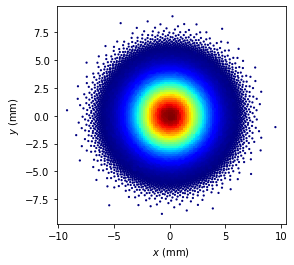

In [58]:
# The distgen module has some basic plotting routines
from distgen.plot import *

units = {"x":"mm","y":"mm","px":"keV/c","py":"keV/c","pz":'keV/c',"t":"ps","q":"pC"}

# plot_2d allows for plotting a 2D subspace of the beam coordinates:

fig=plt.figure(1)
# X-Y Plot
plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

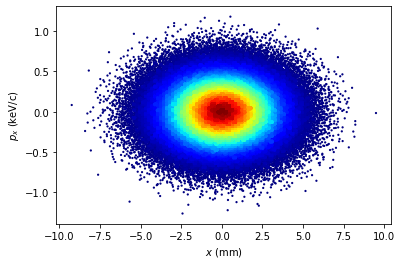

In [59]:
# X-Px Plot
fig.add_subplot(1,3,2)
plot_2d(beam,1,"x",units["x"],"px",units["px"],'scatter_hist2d',nbins=100);

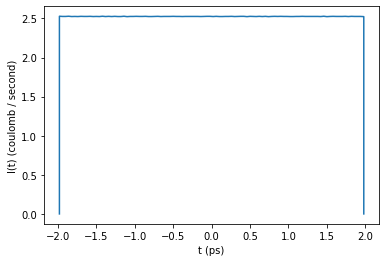

In [60]:
# Laser Current Profile
plot_current_profile(beam, 1, units);

In [61]:
# Cleanup
os.remove('rad.gaussian.gpt.out.txt')
os.remove('rad.gaussian.astra.out.txt')
os.remove('rad.gaussian.openPMD.out.h5')

# Run Distgen function

In [62]:
from distgen.drivers import run_distgen

In [63]:
# All of the above commands can be executed together in one call using the driver
# function run_distgen:
beam = run_distgen(inputs=p, verbose=1)

Ignoring user specified px distribution for cathode start.
Ignoring user specified py distribution for cathode start.
Ignoring user specified pz distribution for cathode start.
Ignoring user specified px distribution for cathode start.
Ignoring user specified py distribution for cathode start.
Ignoring user specified pz distribution for cathode start.
Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution:       Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Scaling sigma_x -> 2.000 mm
   Shifting avg_x -> 0.000 m
   Scaling sigma_y -> 2.000 mm


In [64]:
# Note, the keyword arguement 'inputs' can also take the file name:
beam = run_distgen(inputs='data/rad.gaussian.in.json', verbose=1)

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution:       Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Scaling sigma_x -> 2.000 mm
   Shifting avg_x -> 0.000 m
   Scaling sigma_y -> 2.000 mm
   Shifting avg_y -> 0.000 m
   Scaling sigma_px -> 276.857 eV/c
   Shifting avg_px -> 0.000 eV/c
   Scaling sigma_py -> 276.857 eV/c
   Shifting avg_py -> 0.000 eV/c
   Scaling sigma_pz -> 276.857 eV/c
   Shifting avg_pz -> 0.000 eV/c
   Scaling sigma_t -> 1.155 ps
   Shifting avg_t -> 0.000 ps
   Cathode start: fixing pz momenta to forward hemisphere

In [65]:
# The function can also accept a flattened settings dict, which updates inputs

new_settings = {'beam:params:MTE:value':0.1}
beam = run_distgen(settings=new_settings, inputs=input_file, verbose=1)

Replacing param beam:params:MTE:value with value 0.1
Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution:       Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 7.148 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 7.148 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 7.148 eV/c
   Scaling sigma_x -> 2.000 mm
   Shifting avg_x -> 0.000 m
   Scaling sigma_y -> 2.000 mm
   Shifting avg_y -> 0.000 m
   Scaling sigma_px -> 7.148 eV/c
   Shifting avg_px -> 0.000 eV/c
   Scaling sigma_py -> 7.148 eV/c
   Shifting avg_py -> 0.000 eV/c
   Scaling sigma_pz -> 7.148 eV/c
   Shifting avg_pz -> 0.000 eV/c
   Scaling sigma_t -> 1.155 ps
   Shifting avg_t -> 0.000 ps
   Cathode start

In [66]:
# It is also possible to run distgen as an executible script using /bin/DistGen.py
import subprocess
output=subprocess.check_output(['python','../bin/DistGen.py','-f','data/rad.gaussian.in.json','-v','2'])
output=str(output.decode('utf-8')).split("\n")
for line in output:
    print(line)


Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution:       Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Scaling sigma_x -> 2.000 mm
   Shifting avg_x -> 0.000 m
   Scaling sigma_y -> 2.000 mm
   Shifting avg_y -> 0.000 m
   Scaling sigma_px -> 276.857 eV/c
   Shifting avg_px -> 0.000 eV/c
   Scaling sigma_py -> 276.857 eV/c
   Shifting avg_py -> 0.000 eV/c
   Scaling sigma_pz -> 276.857 eV/c
   Shifting avg_pz -> 0.000 eV/c
   Scaling sigma_t -> 1.155 ps
   Shifting avg_t -> 0.000 ps
   Cathode start: fixing pz momenta to forward hemisphere

# Scaling/Rotating/Shifting Coordinates

The distgen module allows the user with several options for applying coordinate transformations.  Some of the basic operations include: shifting, scaling, and rotating coordinates.  See the transform.ipynb for a detailed description of this functionality. 

# Cathode Start

Currently Distgen supports a single emission model.  Particles emitted from a cathode are assumed to have a Maxwell-Boltzmann distribution for their total mometnum $p$ parameterized by an energy scale denoted $MTE$: 

$\rho_p(p) = \left(\frac{1}{2\pi mMTE}\right)^{3/2} 4\pi p^2 \exp\left(-\frac{p^2}{2m MTE}\right)$, with $\int\rho_p(p)dp = 1$.

Assuming spherical symmetry, it is easy to show the corresponding PDF for the components of the momenta is given by:

$\rho(p_x,p_y,p_z) = \left(\frac{1}{2\pi mMTE}\right)^{3/2}\exp\left(-\frac{p_x^2+p_y^2+p_z^2}{2m MTE}\right)$, with $\int\rho(p_x,p_y,p_z) d^3p=1$.

From the equipartition theorem the average energy $\frac{3}{2}MTE$ is divided equally among each direction and thus the energy scale $MTE$ can be identified as the Mean Transverse Energy: $MTE=\frac{\langle p_x^2\rangle}{2m} + \frac{\langle p_y^2\rangle}{2m}$.  

This expression can be used to relate the MTE to the initial cathode emittance:

$\epsilon_{n,x} = \sigma_{x}\sqrt{ \frac{MTE}{mc^2} }$

assuming there is no distinction between the $p_x$ and $p_y$ distributions inherent to the emission process.  To account for the fact that particles with $p_z<0$ are not emitted from the cathode, distgen takes $p_z = |p_z|$. 

So far, all of the examples shown above describes beam distributions emitted from a cathode.  The input required for cathode start is shown below:

In [39]:
from distgen import Generator
input_file = "data/rad.gaussian.in.json"

gen = Generator(input=input_file,verbose=1)
print('beam:start_type:',gen.input['beam']['start_type'], ', beam:params:MTE:', gen.input['beam']['params']['MTE'])

beam:start_type: cathode , beam:params:MTE: {'value': 150, 'units': 'meV'}


Running the Generator.beam() function with verbose >=1 will show the stats for generation of the momenta. Note the absolute value of the $p_z$ components is taken.

In [38]:
beam = gen.beam()

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution:       Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Scaling sigma_x -> 2.000 mm
   Shifting avg_x -> 0.000 m
   Scaling sigma_y -> 2.000 mm
   Shifting avg_y -> 0.000 m
   Scaling sigma_px -> 276.857 eV/c
   Shifting avg_px -> 0.000 eV/c
   Scaling sigma_py -> 276.857 eV/c
   Shifting avg_py -> 0.000 eV/c
   Scaling sigma_pz -> 276.857 eV/c
   Shifting avg_pz -> 0.000 eV/c
   Scaling sigma_t -> 1.155 ps
   Shifting avg_t -> 0.000 ps
   Cathode start: fixing pz momenta to forward hemisphere

The time coordinate in this case effectively respresents the emission time of the particle from the cathode, and thus the time distribution should be set by the user.  The plots below show the corresponding horizontal and longitudinal phase spaces:

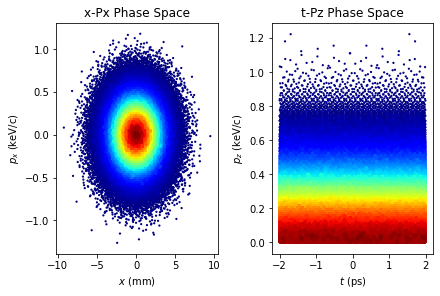

In [46]:
fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)
plot_2d(beam,1,"x",units["x"],"px",units["px"],'scatter_hist2d',nbins=100,ax=ax[0]);
ax[0].set_title('x-Px Phase Space')

plot_2d(beam,1,"t",units["t"],"pz",units["pz"],'scatter_hist2d',nbins=100,ax=ax[1]);
ax[1].set_title('t-Pz Phase Space');

# Time Start

Distgen also allows the user to start a beam at an arbitrary time.  In this case, distgen will ignore any user distribution settings for the time coordinate of the beam particles.